In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
sys.path.append("../../src/md_sim")
from structure_analysis import load_hdf

In [2]:
h5_file                         = "/mnt/TOSHIBA_EXT/Nextcloud/Work/W_PhD/W_PhD_Analysis/Simulations/LAMMPS/free_expansion_airebo_m/airebo_m.h5"
run_dic                         = load_hdf(h5_file)

structure_analysis - DEBUG - Found group key: airebo_m


In [3]:
equilibrated_Press          = {}
simulation_stability        = {'3_35_1000K_8x8x8': 1, '3_35_2000K_8x8x8': 0, \
            '3_35_3000K_8x8x8': 0, '3_35_4000K_8x8x8': 0, '3_45_1000K_8x8x8': 1, \
            '3_45_2000K_8x8x8': 1, '3_45_3000K_8x8x8': 0, '3_45_4000K_8x8x8': 0, \
            '3_4_1000K_8x8x8': 1, '3_4_2000K_8x8x8': 1, '3_4_3000K_8x8x8': 0, \
            '3_4_4000K_8x8x8': 0, '3_5_1000K_8x8x8': 1, '3_5_2000K_8x8x8': 1, \
            '3_5_3000K_8x8x8': 0, '3_5_4000K_8x8x8': 0}
for id, run_key in enumerate(run_dic.keys()):
    if run_key == 'airebo_m':
        continue
    equilibrated_Press.update({run_key : int(np.mean(run_dic[run_key]['thermo_equilibration']['Press'][150:]*1e-4))})
print(equilibrated_Press)

{'3_35_1000K_8x8x8': 136, '3_35_2000K_8x8x8': 147, '3_35_3000K_8x8x8': 158, '3_35_4000K_8x8x8': 168, '3_45_1000K_8x8x8': 62, '3_45_2000K_8x8x8': 72, '3_45_3000K_8x8x8': 81, '3_45_4000K_8x8x8': 89, '3_4_1000K_8x8x8': 95, '3_4_2000K_8x8x8': 106, '3_4_3000K_8x8x8': 116, '3_4_4000K_8x8x8': 125, '3_5_1000K_8x8x8': 35, '3_5_2000K_8x8x8': 44, '3_5_3000K_8x8x8': 52, '3_5_4000K_8x8x8': 58}


In [4]:
def us_to_up(us):
    return (us -  2.64795467)/1.35672363
    #return us * 1.35672363 - 2.64795472

In [5]:
def us_to_P(us):
    p   = np.array([0.01006235,-0.02431597,-0.01331899])
    rho0        = 1.380
    up          = us_to_up(us)
    # values obtained from Julians Hugonito and fit to the data
    return np.polyval(p,us) * 100.
    return rho0 * us * up

In [6]:
def fit_us_up(PET_EOS):
    rho0        = 1.380 # g/cc
    v0          = np.sqrt(PET_EOS['P[Mbar]'] / (rho0 - (rho0**2) / (PET_EOS['rho[g/cc]']) ) )
    v1          = np.sqrt(PET_EOS['P[Mbar]'] / (PET_EOS['rho[g/cc]']**2 / rho0 - PET_EOS['rho[g/cc]'] ) )
    P           = np.array(PET_EOS['P[Mbar]'])
    us          = v0 * 10.
    up          = (us - v1 * 10.)

    us_up   = np.polyfit(up, us, 1)
    us_P    = np.polyfit(us, P, 2)
    
    return np.array(us), np.array(up), us_up, us_P

In [7]:
data                    = np.loadtxt('../../.data_LW03/Hugoniot_PET/hugoniot_mylar_dftmd.txt',skiprows=11)
keys                    = ['rho[g/cc]','rho/rho0','T[K]','E[100kJ/g]','P[Mbar]']
PET_EOS                 = pd.DataFrame(data=data, columns=keys)
LW03                    = pd.read_csv('../../.data_LW03/Hugoniot_PET/LW03_diamond.csv')
LW03_PLA                = pd.read_csv('../../.data_LW03/Hugoniot_PET/LW03_diamond_PLA.csv')
diamond_PS              = pd.read_csv('../../.data_LW03/Hugoniot_PET/diamond_PS.csv')
#diamond_melt            = pd.read_csv('../../.data_LW03/Hugoniot_PET/Diamond_melting_line.csv',skiprows=1)
diamond_melt            = pd.read_csv('../../.data_LW03/Hugoniot_PET/Diamond_melting.csv',skiprows=1)
diamond_melt            = diamond_melt[diamond_melt["P[GPa]"] < 350]
vel_err                 = 0.3
P_err                   = (us_to_P(LW03['us[km/s]'] + vel_err) - us_to_P(LW03['us[km/s]'] - vel_err))/2.
us_to_P(LW03['us[km/s]'])

array([ 82.65665077,  91.69853113,  86.78654316,  91.12179618,
        88.86309221, 141.30026344, 140.05375359, 118.82732633,
        66.17497607,  36.63096505])

[ 0.01006235 -0.02431597 -0.01331899]


114.38683703439179

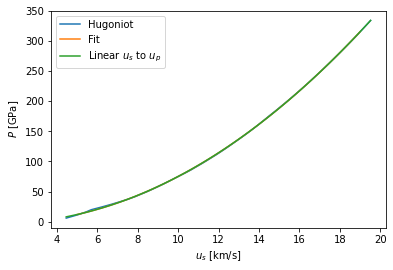

In [8]:
us, up, us_up, us_P = fit_us_up(PET_EOS)

P           = np.array(PET_EOS['P[Mbar]']) *100.

plt.plot(us,P,label='Hugoniot')
plt.xlabel(r'$u_s$ [km/s]')
plt.ylabel(r'$P$ [GPa]')
x   = np.linspace(5,19,100)
y   = np.polyval(us_P,x) * 100.
plt.plot(x,y,label='Fit')

plt.plot(us, us_to_P(us),label=r'Linear $u_s$ to $u_p$')

plt.legend()

print(us_P)

(us_P[0]*10.7 + us_P[1]) * 100.

np.polyval(us_P,12) * 100.

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rc('text', usetex = True)

In [10]:
PET_EOS             = PET_EOS[PET_EOS['T[K]'] < 10000.]
P_vals              = PET_EOS['P[Mbar]']*100.
T_vals              = PET_EOS['T[K]']
mask                = np.where((50. < P_vals) &  (P_vals < 100.))[0]
diamond_mask        = np.where(LW03['diamond'] == 1)[0]
y_interp            = scipy.interpolate.interp1d(P_vals, T_vals)

In [11]:
print(min(y_interp(us_to_P(LW03['us[km/s]'][diamond_mask]))))
print(max(y_interp(us_to_P(LW03['us[km/s]'][diamond_mask]))))

3313.6044917918884
5541.669864045007


In [12]:
def plot_region(fig : matplotlib.pyplot.figure, ax : matplotlib.pyplot.axes, Pmin : float, Pmax : float, Hugoniot :pd.DataFrame):
    P_values        = Hugoniot['P[Mbar]']*100.
    mask            = np.where((Pmin < P_vals) &  (P_vals < Pmax))[0]
    P_values        = P_values[mask]
    T_upper         = Hugoniot['T[K]'][mask] + 400.
    T_lower         = Hugoniot['T[K]'][mask] - 400.
    ax.fill_between(P_values, T_upper, T_lower, color="deepskyblue", alpha=0.1, hatch='|')

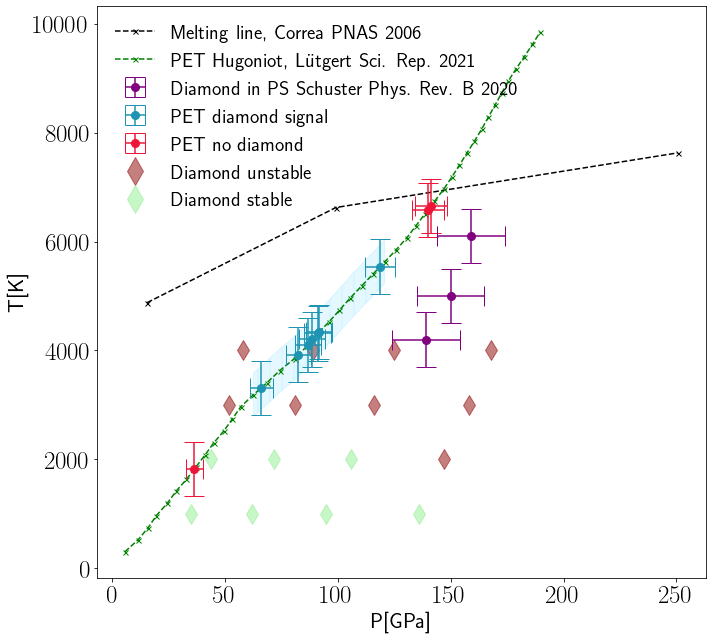

In [13]:
fig, ax             = plt.subplots(figsize=(10, 9))

diamond_line,       = ax.plot(diamond_melt['P[GPa]'],diamond_melt['T[K]'], color='k', linestyle='dashed', marker='x',markersize=5.,label='Diamond melting line, Ghiringhelli Phys. Rev. Lett. 2005')
hugoniot_line,      = ax.plot(PET_EOS['P[Mbar]']*100., PET_EOS['T[K]'],color='green', linestyle='dashed', marker='x',markersize=5.,label='PET Hugoniot, Lütgert Sci. Rep. 2021')

diamond_mask        = np.where(LW03['diamond'] == 1)[0]
no_diamond_mask     = np.where(LW03['diamond'] == 0)[0]

x_values            = us_to_P(LW03['us[km/s]'])[diamond_mask]
x_err               = P_err[diamond_mask]
y_values            = y_interp(x_values)
PET_line            = ax.errorbar(x_values, y_values, xerr=x_err, yerr=500, fmt='o', markersize=8, capsize=10, color='#1e94b2',label='PET diamond signal')

x_values_nodi       = us_to_P(LW03['us[km/s]'])[no_diamond_mask]
x_err_nodi          = P_err[no_diamond_mask]
y_values_nodi       = y_interp(x_values_nodi)
PET_no_diamond      = ax.errorbar(x_values_nodi, y_values_nodi, xerr=x_err_nodi, yerr=500, fmt='o', markersize=8, capsize=10, color='#ef1539',label='PET no diamond')

PS_diamond          = ax.errorbar(diamond_PS["P[GPa]"], diamond_PS["T[K]"], xerr=diamond_PS["deltaP"], yerr=500, fmt='o', markersize=8, capsize=10, color='purple',label='PS diamond')

color      = {0: 'darkred', 1: 'lightgreen'}
for id, run_key in enumerate(run_dic.keys()):
    if run_key == 'airebo_m':
        continue
    T           = int(run_dic[run_key]['metadata']['temperature'])
    P           = equilibrated_Press[run_key]
    ax.scatter(P,T,marker='d',color=color[simulation_stability[run_key]],s=200.,alpha=0.5)

from matplotlib.lines import Line2D
experiment_legend            = [diamond_line,hugoniot_line, PS_diamond, PET_line, PET_no_diamond]
[experiment_legend.append(Line2D([], [], c=color[a], marker='d', lw=1.,markersize=20.,alpha=0.5,linestyle="None")) for a in [0,1]]
handles                      = ['Melting line, Correa PNAS 2006', 'PET Hugoniot, Lütgert Sci. Rep. 2021', 'Diamond in PS Schuster Phys. Rev. B 2020','PET diamond signal','PET no diamond','Diamond unstable','Diamond stable']



ax.set_ylabel(r'T[K]',fontsize=22)
ax.set_xlabel(r'P[GPa]',fontsize=22)
plot_region(fig, ax,np.min(x_values)-np.min(x_err),np.max(x_values)+np.max(x_err),PET_EOS)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
#ax.legend(fontsize=20)
ax.legend(experiment_legend, handles,fontsize=20,loc='upper left',frameon=False)
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/PET_phase.pdf')

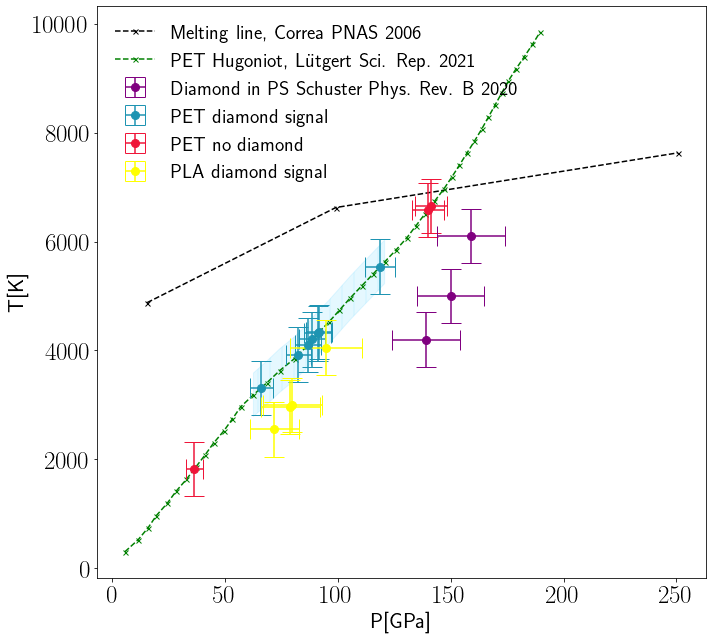

In [14]:
fig, ax             = plt.subplots(figsize=(10, 9))

diamond_line,       = ax.plot(diamond_melt['P[GPa]'],diamond_melt['T[K]'], color='k', linestyle='dashed', marker='x',markersize=5.,label='Diamond melting line, Ghiringhelli Phys. Rev. Lett. 2005')
hugoniot_line,      = ax.plot(PET_EOS['P[Mbar]']*100., PET_EOS['T[K]'],color='green', linestyle='dashed', marker='x',markersize=5.,label='PET Hugoniot, Lütgert Sci. Rep. 2021')

diamond_mask        = np.where(LW03['diamond'] == 1)[0]
no_diamond_mask     = np.where(LW03['diamond'] == 0)[0]

diamond_mask_PLA    = np.where(LW03_PLA['diamond'] == 1)[0]
no_diamond_mask_PLA = np.where(LW03_PLA['diamond'] == 0)[0]


x_values            = us_to_P(LW03['us[km/s]'])[diamond_mask]
x_err               = P_err[diamond_mask]
y_values            = y_interp(x_values)
PET_line            = ax.errorbar(x_values, y_values, xerr=x_err, yerr=500, fmt='o', markersize=8, capsize=10, color='#1e94b2',label='PET diamond signal')

x_values_PLA        = LW03_PLA['P[GPa]'][diamond_mask_PLA]
x_err_PLA           = LW03_PLA['deltaP'][diamond_mask_PLA]
y_values_PLA        = LW03_PLA['T[K]'][diamond_mask_PLA]
PET_line_PLA        = ax.errorbar(x_values_PLA, y_values_PLA, xerr=x_err_PLA, yerr=500, fmt='o', markersize=8, capsize=10, color='yellow',label='PLA diamond signal')

x_values_PLA_nodi   = LW03_PLA['P[GPa]'][no_diamond_mask_PLA]
x_err_PLA_nodi      = LW03_PLA['deltaP'][no_diamond_mask_PLA]
y_values_PLA_nodi   = LW03_PLA['T[K]'][no_diamond_mask_PLA]
#PET_line_PLA_nodi   = ax.errorbar(x_values_PLA_nodi, y_values_PLA_nodi, xerr=x_err_PLA_nodi, yerr=500, fmt='o', markersize=8, capsize=10, color='orange',label='PLA no diamond signal')

x_values_nodi       = us_to_P(LW03['us[km/s]'])[no_diamond_mask]
x_err_nodi          = P_err[no_diamond_mask]
y_values_nodi       = y_interp(x_values_nodi)
PET_no_diamond      = ax.errorbar(x_values_nodi, y_values_nodi, xerr=x_err_nodi, yerr=500, fmt='o', markersize=8, capsize=10, color='#ef1539',label='PET no diamond')

PS_diamond          = ax.errorbar(diamond_PS["P[GPa]"], diamond_PS["T[K]"], xerr=diamond_PS["deltaP"], yerr=500, fmt='o', markersize=8, capsize=10, color='purple',label='PS diamond')

color      = {0: 'darkred', 1: 'lightgreen'}

from matplotlib.lines import Line2D
experiment_legend            = [diamond_line,hugoniot_line, PS_diamond, PET_line,PET_no_diamond,PET_line_PLA]
handles                      = ['Melting line, Correa PNAS 2006', 'PET Hugoniot, Lütgert Sci. Rep. 2021', 'Diamond in PS Schuster Phys. Rev. B 2020','PET diamond signal','PET no diamond','PLA diamond signal']


ax.set_ylabel(r'T[K]',fontsize=22)
ax.set_xlabel(r'P[GPa]',fontsize=22)
plot_region(fig, ax,np.min(x_values)-np.min(x_err),np.max(x_values)+np.max(x_err),PET_EOS)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
#ax.legend(fontsize=20)
ax.legend(experiment_legend, handles,fontsize=20,loc='upper left',frameon=False)
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/PET_phase_part1.pdf')

In [104]:
print(f'Mean pressure for 36J shots is: %.1f +/- %.1f GPa' %(np.mean(x_values[1:-1]),np.sqrt(np.sum((x_err[1:-1])**2))))
print(f'Tmeperature is {int(np.mean(y_values[1:-1]))} K')

Mean pressure for 36J shots is: 89.4 +/- 11.6 GPa
Tmeperature is 4226 K


In [118]:
x_values            = us_to_P(LW03['us[km/s]'])[diamond_mask]
x_err               = P_err[diamond_mask]
y_values            = y_interp(x_values)
print(y_values)
print(x_values)

[3923.25896553 4336.44750931 4097.79756924 4312.27056315 4202.07024752
 3313.60449179]
[82.65665077 91.69853113 86.78654316 91.12179618 88.86309221 66.17497607]


In [113]:
82.65665077,  91.69853113,  86.78654316,  91.12179618, 88.86309221, 141.30026344, 140.05375359, 118.82732633, 66.17497607,  36.63096505

(82.65665077,
 91.69853113,
 86.78654316,
 91.12179618,
 88.86309221,
 141.30026344,
 140.05375359,
 118.82732633,
 66.17497607,
 36.63096505)

In [107]:
LW03

,us[km/s],diamond,run
0,10.423905,1,78
1,10.899183,1,182
2,10.643960,1,186
3,10.869565,1,188
4,10.752688,1,190
5,13.175231,0,279
6,13.123360,0,282
7,12.202563,0,286
8,9.487666,1,289
9,7.468260,0,298
